# Experiments on the PhD Exchange Network
# This code reproduces the results in the Book Chapter
##  https://arxiv.org/abs/1906.06366

### Dane Taylor, 4 January 2021


In [2]:
%pylab inline
import networkx as nx
import seaborn as sns
from scipy import sparse
import sys,os

Populating the interactive namespace from numpy and matplotlib


## 1. Set up folders for code, data, and figures

In [3]:
# folder containing supracentrality codes
code_folder = '../supracentrality/' 
sys.path.append(code_folder)

In [4]:
from supracentrality import *
from load_PhD_exchange import *

In [5]:
# folder containing data
data_folder = '../data/PhD Exchange Network Data' 

# folder where to save figures
fig_folder = 'figs' 
if os.path.isdir(fig_folder)==False: os.mkdir(fig_folder) 

## 2. Load and visualize PhD Exchange data
### https://sites.google.com/site/danetaylorresearch/data



#### First, for visualization purposes, create a network that aggregates all data into a single network


In [6]:
PhD_graph = load_PhD_flow_graph(data_folder)
#spy(PhD_graph['A']);

/anaconda3/envs/py_nx/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Loaded network with:
231 nodes
10365 edges


In [7]:
# COMPUTE REVERSE PAGERANK
x = pagerank(PhD_graph['A'].T,0.85)
top10_ids = argsort(-x)[:10]
print(top10_ids)
print()
print(x[top10_ids])

[ 51 130  77  89  38 112  24  12  23 201]

[0.09490866 0.07441377 0.07373011 0.07353183 0.07039621 0.03062513
 0.02649876 0.02282752 0.02221068 0.02121141]


In [8]:
top10_schools = [ PhD_graph['nodenames'][idd] for idd in top10_ids ]
top10_schools

['Massachusetts Institute of Technology',
 'University of California, Berkeley',
 'Princeton University',
 'Stanford University',
 'Harvard University',
 'The University of Chicago',
 'Cornell University',
 'California Institute of Technology',
 'Columbia University',
 'University of Wisconsin-Madison']

#### Visualize network containing all PhD exchanges with node size/color indicating PageRank

In [9]:
def visualize_network(A,labbels,show_labels,show_floating_nodes):
    A = A.todense()
    ids = range(len(A))
    if ~show_floating_nodes:
        N_temp  = len(A)
        ids = np.where(np.sum(A,1))[0]
        A = A[ids,:]
        A = A[:,ids]  
        labbels = [labbels[i] for i in ids]
        
    G = nx.from_numpy_matrix(A)
    x = abs(np.array(list(nx.pagerank(G, alpha=0.85).values()))) + 10**-14
    pos = pos = nx.kamada_kawai_layout(G)


    fig = figure(figsize=(15,15));
    nodes = nx.draw_networkx_nodes(G, pos,alpha=.4,node_size=x*10**4,node_color=x,cmap='hot')
    edges = nx.draw_networkx_edges(G, pos,alpha=.2,width=.5)
    
    if show_labels:
        labels = {}
        for j in range(len(labbels)):
            labels[j] = labbels[j]
        labels2 = nx.draw_networkx_labels(G, pos,labels,font_size=8,alpha=0.5);
        
    plt.axis('off');
    print('visualizing '+ str(len(ids)) + ' nodes' )    
    return

visualizing 169 nodes


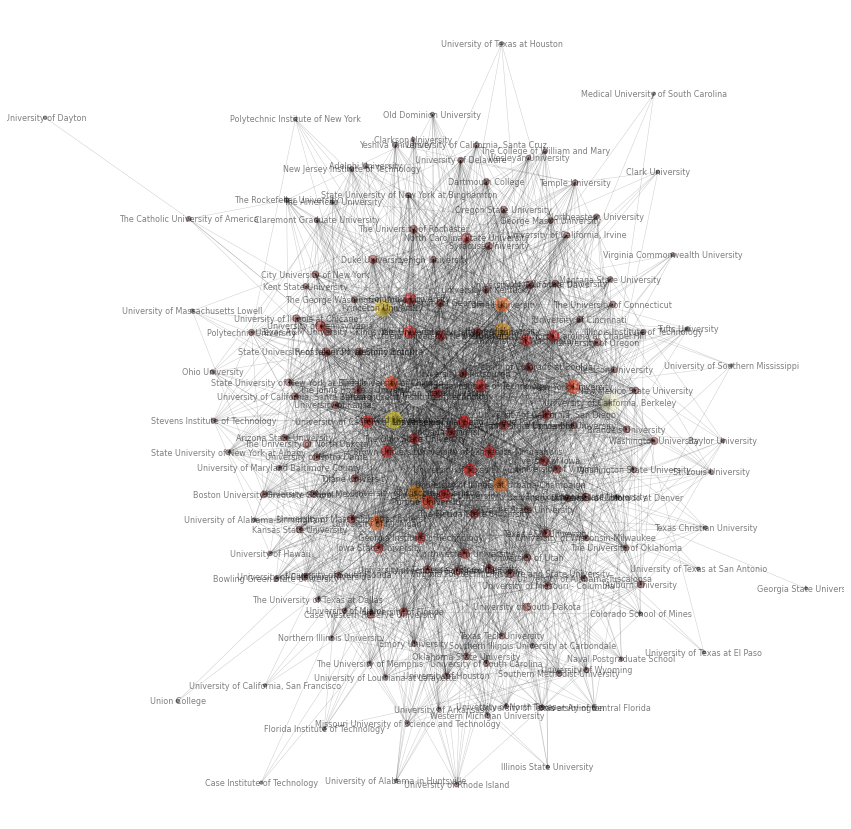

In [10]:
show_labels = True
show_floating_nodes = False
visualize_network(PhD_graph['A'],PhD_graph['nodenames'],show_labels,show_floating_nodes)

#### Now, create a temporal network with each time layer encoding PhD exchanges for a given year

In [11]:
temporal_PhD_graph = load_temporal_PhD_flow_graph(data_folder)

year = 1995

visualizing 58 nodes


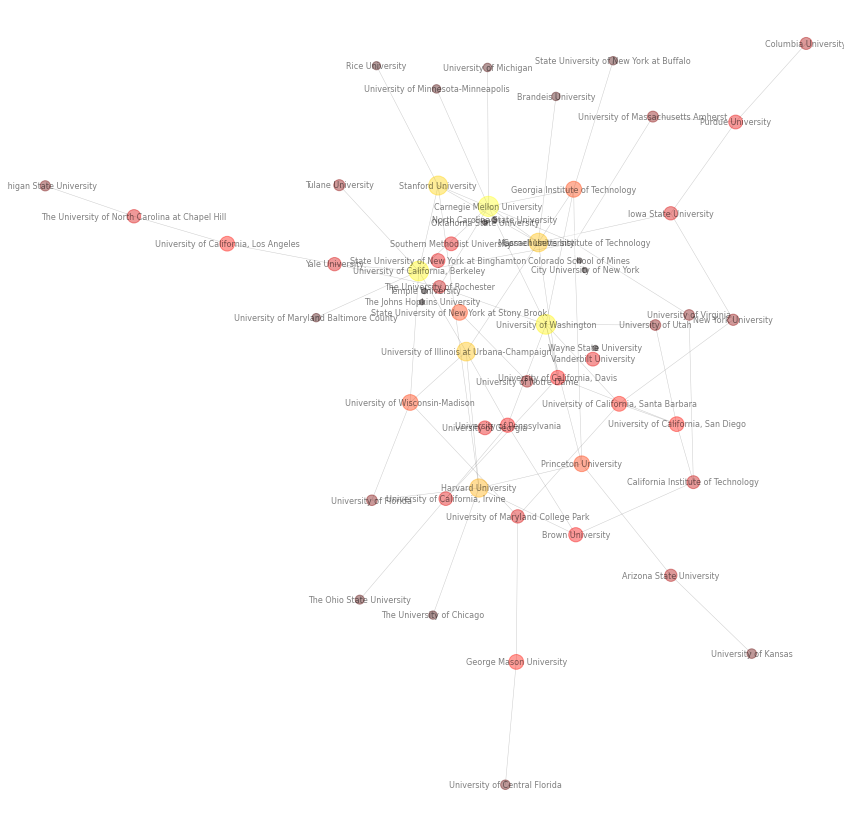

In [12]:
year_id = 49
show_labels = True
show_floating_nodes = False
print('year = '+ str(temporal_PhD_graph['layer_names'][year_id])+'\n')
visualize_network(temporal_PhD_graph['A_tensor'][year_id],temporal_PhD_graph['nodenames'],show_labels,show_floating_nodes)

## 4. Study supracentrality for temporal network encoding PhD exchanges

In [23]:
M = [A.T for A in temporal_PhD_graph['A_tensor']] #Loads temporal graph
At = undirected_chain(len(M))


In [24]:
def plotter(c,c2,omega,alpha,ids):
    names = ['joint supracentrality','conditional centrality']
    fig = plt.figure(figsize = (17,5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    for n in ids:
        ax1.plot(temporal_PhD_graph['layer_names'],c[n]);
    ax1.legend(['Harvard', 'MIT', 'Princeton', 'Stanford', 'UC Berkeley']);
    ax1.set_xticks(['1950','1960','1970','1980','1990','2000']);
    ax1.set_xlabel('Year');
    ax1.set_ylabel(names[0]);
    ax1.set_title(names[0]+', omega='+str(omega)+', alpha='+str(alpha)+'');
    for n in ids:
        ax2.plot(temporal_PhD_graph['layer_names'],c2[n]);
    ax2.legend(['Harvard', 'MIT', 'Princeton', 'Stanford', 'UC Berkeley']);
    ax2.set_xticks(['1950','1960','1970','1980','1990','2000']);
    ax2.set_xlabel('Year');
    ax2.set_ylabel(names[1]);
    ax2.set_title(names[1]+', omega='+str(omega)+', alpha='+str(alpha)+'');    
    return

In [27]:
#for the centrality matrix, use the Google matrix transpose
centrality_matrix_type = 'pagerank' # or adjacency, or hub, authority

if centrality_matrix_type == 'adjacency':
    centrality_function = lambda A: A.todense()
    
if centrality_matrix_type == 'pagerank':
    alpha=0.85
    centrality_function = lambda A: google_matrix(A,alpha=alpha).T

if centrality_matrix_type == 'hub':
    centrality_function = lambda A: np.dot(A.todense(),A.todense().T)

if centrality_matrix_type == 'authority':
    centrality_function = lambda A: np.dot(A.todense().T,A.todense())

#centrality_function(M[1])

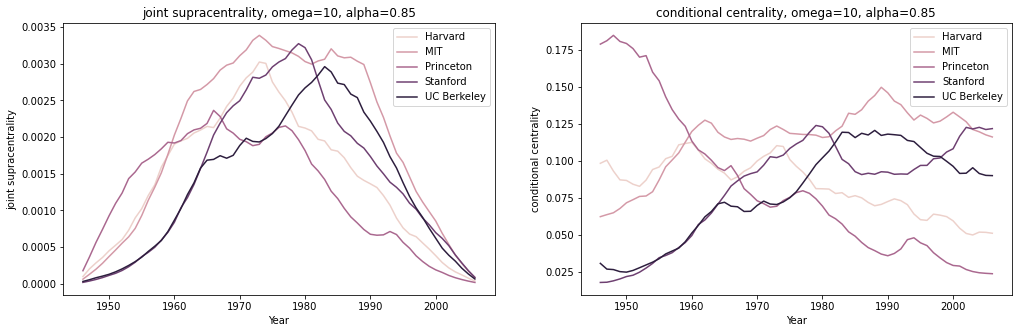

In [28]:
ids = [38,51,77,89,130]
omega = 10
joints = supraCentrality(M,At,omega,centrality_function)
marginals,conditionals = get_marginal_and_conditional(joints)
with sns.cubehelix_palette(5): 
    plotter(joints,conditionals,omega,alpha,ids)

In [29]:
def plotter2(omegas,
             alpha,
             ids,
             Att):    

    fig = plt.figure(figsize = (10,4))
    textures = ['-','-','-','-','-']
    names = ['joint centrality','conditional centrality']


    for i,omega in enumerate(omegas):
        print(omega)
        centrality_function = lambda A: google_matrix(A,alpha=alpha).T
        joints = supraCentrality(M,Att,omega,centrality_function)
        marginals,conditionals = get_marginal_and_conditional(joints)

        ax1 = fig.add_subplot(2,len(omegas),i+1)
        ax2 = fig.add_subplot(2,len(omegas),i+1+len(omegas))
        for ii,n in enumerate(ids):
            ax1.plot(temporal_PhD_graph['layer_names'],joints[n],textures[ii]);        
        #ax1.set_xticks(['1950','1960','1970','1980','1990','2000']);
        ax1.set_xticks(['1950','1970','1990','2010']);        
        #ax1.set_xlabel('year');
        
        #ax1.set_title(names[0]+', omega='+str(omega)+', alpha='+str(alpha)+'');
        ax1.set_title('$\omega='+str(omega)+'$');            
        for ii,n in enumerate(ids):
            ax2.plot(temporal_PhD_graph['layer_names'],conditionals[n],textures[ii]);
            
        #ax2.legend(['Harvard', 'MIT', 'Princeton', 'Stanford', 'UC Berkeley']);
        #ax2.set_xticks(['1950','1960','1970','1980','1990','2000']);
        ax2.set_xticks(['1950','1970','1990','2010']);
        ax2.set_xlabel('year');
        
        #ax2.set_title(names[1]+', omega='+str(omega)+', alpha='+str(alpha)+'');    
        #ax2.set_title('$\omega='+str(omega));    
        
        if i==0:
            #ax1.legend(['Harvard', 'MIT', 'Princeton', 'Stanford', 'UC Berkeley']);           
            ax1.set_ylabel(names[0]);
            ax2.set_ylabel(names[1]);
            
        #ax1.set_ylim([0,.01])    
        #ax2.set_ylim([0,.25])            
        plt.subplots_adjust(top=0.99, bottom=0.01, left=0.01, right=0.99, hspace=0.25,wspace=0.3)
        plt.tight_layout()
        if i==3:
            x = sparse_power_method(Att) 
            ax1.plot( temporal_PhD_graph['layer_names'],
                     x*mean(joints[51,:])*shape(joints)[1],'k:',linewidth=2)
            
    fname = fig_folder+'/undirected_chain.pdf'
    savefig(fname,pad_inches=0.1)
    return

## Undirected coupling of time layers

#### This code makes Fig. 3 in book chapter

1
10
100
1000


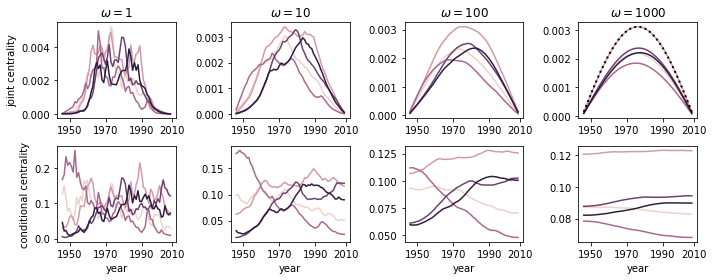

In [30]:
alpha = .85 #pagerank constant
ids = [38,51,77,89,130]# indices of top 5 schools
omegas = [1,10,100,1000]
with sns.cubehelix_palette(5): 
    plotter2(omegas,alpha,ids,At)

# Now directed interlayer coupling

In [31]:
def plotter3(omegas,
             alpha,
             gamma,
             ids,
             names,
             Att,
             fig_folder):
    
    fig = plt.figure(figsize = (10,4))
    
    for i,omega in enumerate(omegas):
        print(omega)
        centrality_function = lambda A: google_matrix(A,alpha=alpha).T
        joints = supraCentrality(M,Att,omega,centrality_function)        
        #joints = supraCentrality(M,Att,omega,alpha)
        marginals,conditionals = get_marginal_and_conditional(joints)

        ax1 = fig.add_subplot(2,len(omegas),i+1)
        ax2 = fig.add_subplot(2,len(omegas),i+1+len(omegas))
        for n in ids:
            ax1.plot(temporal_PhD_graph['layer_names'],joints[n]);        

        ax1.set_xticks(['1950','1970','1990','2010']);        
        ax1.set_title('$\omega='+str(omega)+'$');            
        for n in ids:
            ax2.plot(temporal_PhD_graph['layer_names'],conditionals[n]);
            
        ax2.set_xticks(['1950','1970','1990','2010']);
        ax2.set_xlabel('year');
                
        plt.subplots_adjust(top=0.99, bottom=0.01, left=0.01, right=0.99, hspace=0.25,wspace=0.3)
        plt.tight_layout()
        if i==3:
            x = sparse_power_method(Att)    
            ax1.plot(temporal_PhD_graph['layer_names'],x*mean(joints[51,:])*shape(joints)[1],'k:',linewidth=2)

    fname = fig_folder+'/B_gamma='+str(gamma)+'.pdf'
    savefig(fname,pad_inches=0.1)
    return



## Directed coupling of time layers

#### This code makes Fig. 4 in book chapter

0.1
1
10
100


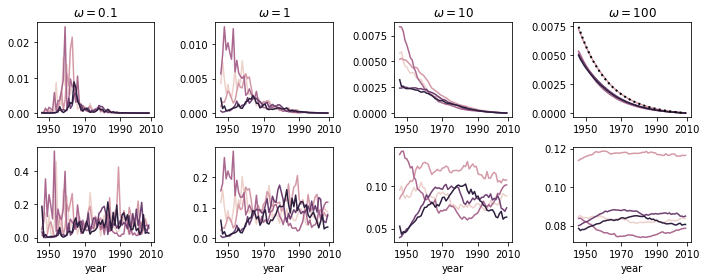

In [32]:
omegas = [.1,1,10,100]
names = ['joint centrality','conditional centrality']
fig_folder = 'figs'

gamma = .0001
At2 = directed_chain(len(M),gamma)

with sns.cubehelix_palette(5): 
    plotter3(omegas,alpha,gamma,ids,names,At2,fig_folder)

0.1
1
10
100


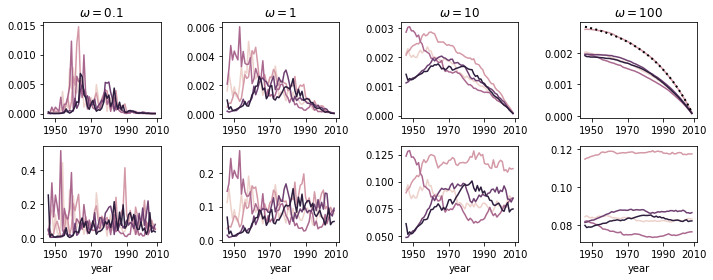

In [33]:
gamma = .001
At2 = directed_chain(len(M),gamma)
with sns.cubehelix_palette(5): 
    plotter3(omegas,alpha,gamma,ids,names,At2,fig_folder)

0.1
1
10
100


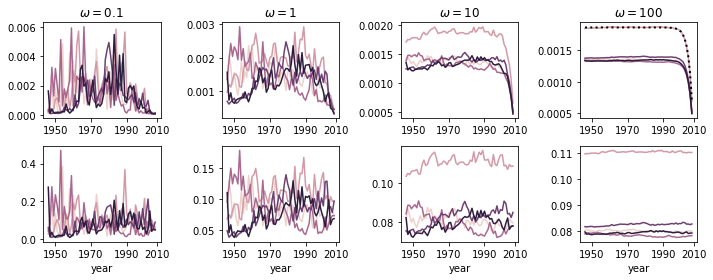

In [34]:
gamma = .01
At2 = directed_chain(len(M),gamma)
with sns.cubehelix_palette(5): 
    plotter3(omegas,alpha,gamma,ids,names,At2,fig_folder)

## Reverse the direction of interlayer coupling

#### This code makes Fig. 5 in book chapter

0.1
1
10
100


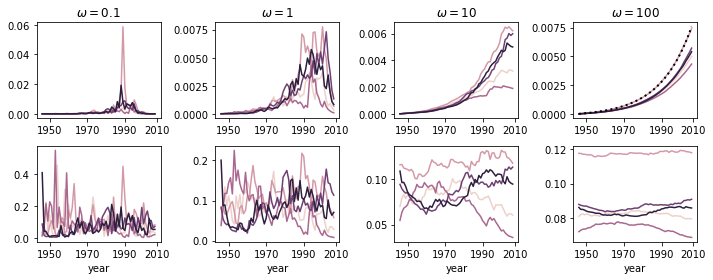

In [35]:
gamma = .0001
At2 = directed_chain(len(M),gamma)
with sns.cubehelix_palette(5): 
    plotter3(omegas,alpha,gamma,ids,names,At2.T,fig_folder)

0.1
1
10
100


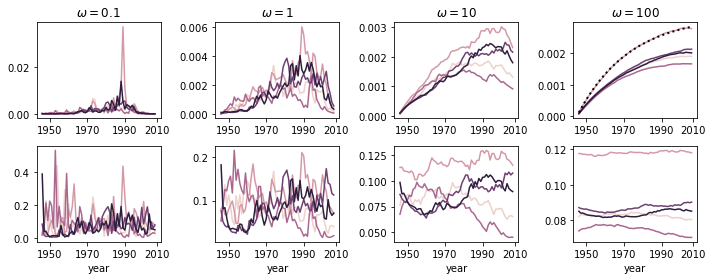

In [36]:
gamma = .001
At2 = directed_chain(len(M),gamma)
with sns.cubehelix_palette(5): 
    plotter3(omegas,alpha,gamma,ids,names,At2.T,fig_folder)

0.1
1
10
100


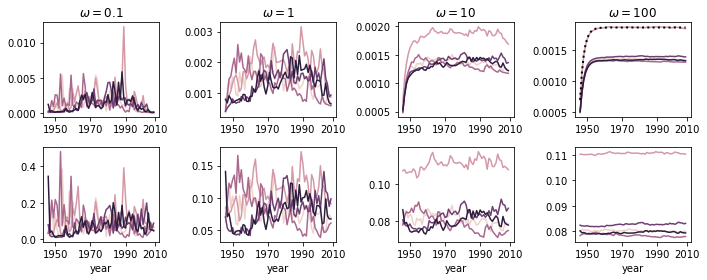

In [37]:
gamma = .01
At2 = directed_chain(len(M),gamma)
with sns.cubehelix_palette(5): 
    plotter3(omegas,alpha,gamma,ids,names,At2.T,fig_folder)